#   Settings and Imports

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from pathlib import Path
from tqdm.notebook import tqdm

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import GRU, Dense, RNN, GRUCell, Input
from tensorflow.keras.losses import BinaryCrossentropy, MeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.utils import plot_model

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.cm import rainbow

In [2]:
gpu_device = tf.config.list_physical_devices('GPU')
tf.config.get_visible_devices('GPU')
if gpu_device:
    print('Can use GPU')
    tf.config.experimental.set_memory_growth(gpu_device[0], True)
else:
    print('Can use only CPU')

Can use only CPU


In [3]:
np.random.seed(42)
tf.random.set_seed(1234)

# Creating Folders

In [4]:
gan_experiment_path = Path('GAN_DATA')
if not gan_experiment_path.exists():
    gan_experiment_path.mkdir()
    print('Create Folder')

In [5]:
experiment_number = 0
logger_directory = gan_experiment_path / f"experiment_{experiment_number:02}"
if not logger_directory.exists():
    logger_directory.mkdir(parents=True)
    print('Create Logger Directory')

In [6]:
hdf_store = gan_experiment_path / 'TimeSeriesGAN.h5'

In [7]:
#   Задел на будущее, у меня есть 3000+ уникальных тикеров с историей цен, если буду обладать
#   вычислительной мощностью, то можно попробовать обучить GAN на такой большой выборке
"""
input_raw_data = pd.read_csv("/Users/molozey/Desktop/AlgoTrade/Глава 4/storage/WIKI_PRICES.csv",
                             index_col='date', parse_dates=['date'])
input_raw_data.info()
"""

'\ninput_raw_data = pd.read_csv("/Users/molozey/Desktop/AlgoTrade/Глава 4/storage/WIKI_PRICES.csv",\n                             index_col=\'date\', parse_dates=[\'date\'])\ninput_raw_data.info()\n'

In [8]:
input_raw_data = pd.read_csv("data_storage/easy_dataset.csv", index_col='date',
                             parse_dates=['date'])
input_raw_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4586 entries, 2000-01-03 to 2018-03-27
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   BA      4586 non-null   float64
 1   CAT     4586 non-null   float64
 2   DIS     4586 non-null   float64
 3   GE      4586 non-null   float64
 4   IBM     4586 non-null   float64
 5   KO      4586 non-null   float64
dtypes: float64(6)
memory usage: 250.8 KB


In [9]:
#sequence_length = 40
sequence_length = 24 #  Как в статье
numbers_sequences = 6 # Number of unique tickers
batch_size = 128

In [10]:
tickers = ["BA", "CAT", "DIS", "GE", "IBM", "KO"]
colors = rainbow(np.linspace(0,1, len(tickers)))

#   Little plotting

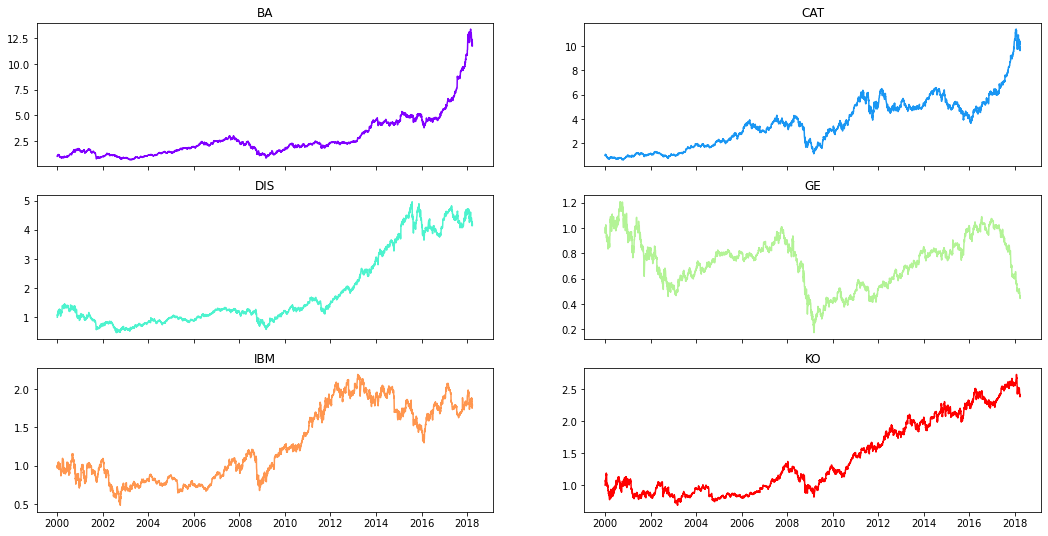

In [11]:
figure, ax = plt.subplots(3, 2, sharex=True, figsize=(18, 9))
ticker_arrow = 0
for i, _ in enumerate(ax):
    for j, __ in enumerate(_):
        ax[i][j].set_title(tickers[ticker_arrow], fontsize=12)
        ax[i][j].plot(input_raw_data[tickers[ticker_arrow]].div(input_raw_data[tickers[ticker_arrow]][0]), color=colors[ticker_arrow])
        ticker_arrow += 1   #   Dumb way

#   Check Correlation

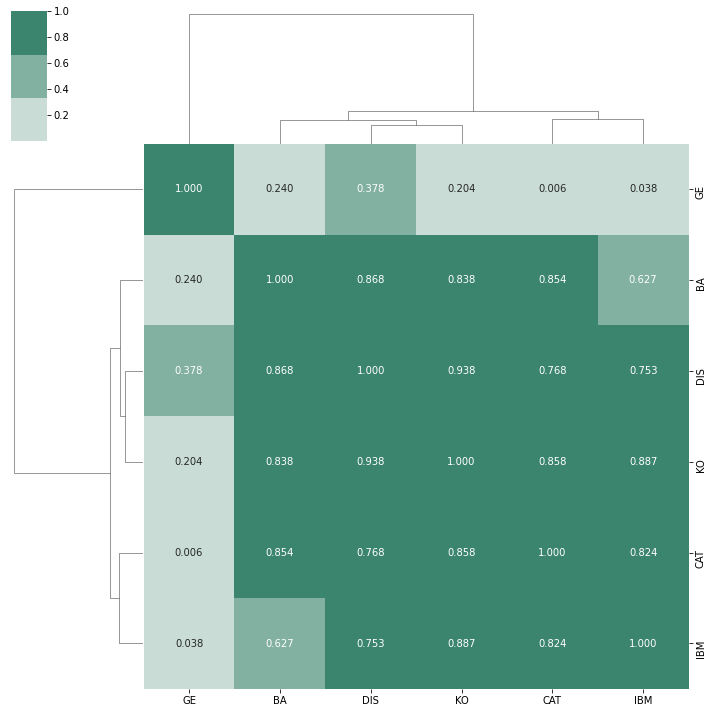

In [12]:
sns.clustermap(input_raw_data.corr(method='pearson'), annot=True, fmt='.3f',
               cmap=sns.diverging_palette(h_neg=20, h_pos=520), center=0)

#   Preprocessing data
Using MinMaxScaler from scikit-learn

In [13]:
sk_scaler = MinMaxScaler()
scaled_data = sk_scaler.fit_transform(input_raw_data).astype(np.float32)

In [14]:
data = list()
for i in range(len(input_raw_data) - sequence_length):
    data.append(scaled_data[i:i + sequence_length])

n_windows = len(data)

In [15]:
real_time_series = (tf.data.Dataset.from_tensor_slices(data).shuffle(buffer_size=n_windows).batch(batch_size))
real_time_series_iter = iter(real_time_series.repeat())

2021-08-31 17:22:02.043971: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


#   Create Random Time Series Generator

In [16]:
def make_random_time_series():
    while True:
        yield np.random.uniform(low=0, high=1, size=(sequence_length, numbers_sequences))

random_time_series = iter(tf.data.Dataset.from_generator(make_random_time_series, output_types=tf.float32)
                          .batch(batch_size).repeat())

2021-08-31 17:22:02.480777: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


#   Creating TimeGAN architecture

In [17]:
#hidden_layers_dim = 40
hidden_layers_dim = 24
#hidden_layers_dim = 64
number_layers = 3

In [18]:
#   Setup logger component
writer = tf.summary.create_file_writer(logger_directory.as_posix())

In [19]:
#   Inputs
X = Input(shape=[sequence_length, numbers_sequences], name='RealData')
Z = Input(shape=[sequence_length, numbers_sequences], name='RandomData')

In [20]:
#   RNN block generator
def make_rnn(n_layers, hidden_units, output_units, name):
    return Sequential([GRU(units=hidden_units, return_sequences=True, name=f'GRU_{i+1}') for i in range(n_layers)]
                      + [Dense(units=output_units, activation="sigmoid", name="OUT")], name=name)

In [21]:
#   Auto-encoder
embedder = make_rnn(n_layers=number_layers, hidden_units=hidden_layers_dim,
                    output_units=hidden_layers_dim, name='Embedder')
recovery = make_rnn(n_layers=number_layers, hidden_units=hidden_layers_dim,
                    output_units=numbers_sequences, name='Recovery')

In [22]:
#   Generator and Discriminator
generator = make_rnn(n_layers=number_layers, hidden_units=hidden_layers_dim,
                     output_units=hidden_layers_dim, name='Generator')
discriminator = make_rnn(n_layers=number_layers, hidden_units=hidden_layers_dim,
                         output_units=1, name='Discriminator')
supervisor = make_rnn(n_layers=number_layers-1, hidden_units=hidden_layers_dim,
                      output_units=hidden_layers_dim, name='Supervisor')

#   Train Part

In [23]:
train_steps = 100000
gamma = 1
#   Creating generic loss functions
mse = MeanSquaredError()
bce = BinaryCrossentropy()

#   Auto-encoder

In [24]:
H = embedder(X)
X_tilde = recovery(H)
autoencoder = Model(inputs=X, outputs=X_tilde, name='Autoencoder')

In [25]:
autoencoder.summary()

Model: "Autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
RealData (InputLayer)        [(None, 40, 6)]           0         
_________________________________________________________________
Embedder (Sequential)        (None, 40, 40)            27080     
_________________________________________________________________
Recovery (Sequential)        (None, 40, 6)             29766     
Total params: 56,846
Trainable params: 56,846
Non-trainable params: 0
_________________________________________________________________


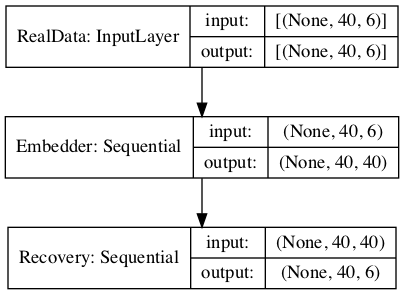

In [26]:
plot_model(autoencoder, to_file=(gan_experiment_path / 'autoencoder.png').as_posix(), show_shapes=True)

In [27]:
#   Creating Auto-encoder optimizer
autoencoder_optimizer = Adam()

In [28]:
#   Create Auto-encoder step
@tf.function
def train_autoencoder_init(x):
    with tf.GradientTape() as tape:
        x_tilde = autoencoder(x)
        embedding_loss_t0 = mse(x, x_tilde)
        e_loss_t0 = 10 * tf.sqrt(embedding_loss_t0)

    var_list = embedder.trainable_variables + recovery.trainable_variables
    gradients = tape.gradient(e_loss_t0, var_list)
    autoencoder_optimizer.apply_gradients(zip(gradients, var_list))
    return tf.sqrt(embedding_loss_t0)

In [29]:
#   Auto-encoder training loop
for step in tqdm(range(train_steps)):
    _X = next(real_time_series_iter)
    _step_e_loss_t0 = train_autoencoder_init(_X)
    with writer.as_default():
        tf.summary.scalar('Loss auto-encoder init', _step_e_loss_t0, step=step)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [30]:
###
autoencoder.save(logger_directory / 'autoencoder')
###

INFO:tensorflow:Assets written to: GAN_DATA/experiment_00/autoencoder/assets


2021-08-31 17:33:46.318901: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
INFO:tensorflow:Assets written to: GAN_DATA/experiment_00/autoencoder/assets


In [31]:
supervisor_optimizer = Adam()

In [32]:
#   Create supervisor step
@tf.function
def train_supervisor(x):
    with tf.GradientTape() as tape:
        h = embedder(x)
        h_hat_supervised = supervisor(h)
        g_loss_s = mse(h[:, 1:, :], h_hat_supervised[:, 1:, :])

    var_list = supervisor.trainable_variables
    gradients = tape.gradient(g_loss_s, var_list)
    supervisor_optimizer.apply_gradients(zip(gradients, var_list))
    return g_loss_s

In [33]:
#   Supervisor training loop
for step in tqdm(range(train_steps)):
    _X = next(real_time_series_iter)
    step_g_loss_s = train_supervisor(_X)
    with writer.as_default():
        tf.summary.scalar('Loss generator supervised init', step_g_loss_s, step=step)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [34]:
###
supervisor.save(logger_directory / 'supervisor')
###

INFO:tensorflow:Assets written to: GAN_DATA/experiment_00/supervisor/assets


INFO:tensorflow:Assets written to: GAN_DATA/experiment_00/supervisor/assets


In [35]:
#   Generator
E_hat = generator(Z)
H_hat = supervisor(E_hat)
Y_fake = discriminator(H_hat)

adversarial_supervised = Model(inputs=Z, outputs=Y_fake, name='AdversarialNetSupervised')

In [36]:
adversarial_supervised.summary()

Model: "AdversarialNetSupervised"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
RandomData (InputLayer)      [(None, 40, 6)]           0         
_________________________________________________________________
Generator (Sequential)       (None, 40, 40)            27080     
_________________________________________________________________
Supervisor (Sequential)      (None, 40, 40)            21320     
_________________________________________________________________
Discriminator (Sequential)   (None, 40, 1)             29561     
Total params: 77,961
Trainable params: 77,961
Non-trainable params: 0
_________________________________________________________________


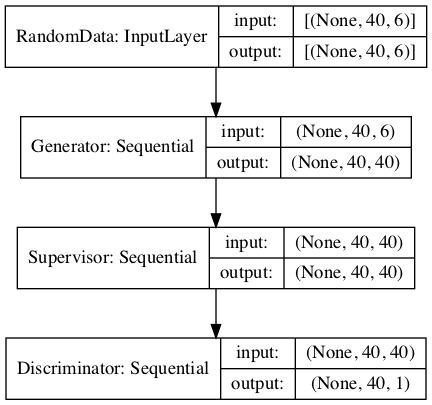

In [37]:
plot_model(adversarial_supervised, show_shapes=True)

In [38]:
Y_fake_e = discriminator(E_hat)

adversarial_emb = Model(inputs=Z, outputs=Y_fake_e,
                        name='AdversarialNet')
adversarial_emb.summary()

Model: "AdversarialNet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
RandomData (InputLayer)      [(None, 40, 6)]           0         
_________________________________________________________________
Generator (Sequential)       (None, 40, 40)            27080     
_________________________________________________________________
Discriminator (Sequential)   (None, 40, 1)             29561     
Total params: 56,641
Trainable params: 56,641
Non-trainable params: 0
_________________________________________________________________


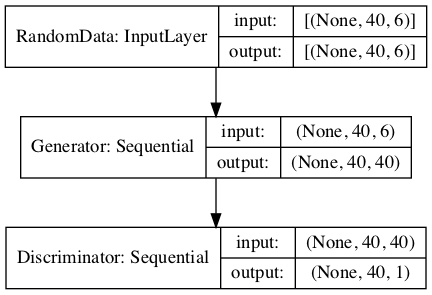

In [39]:
plot_model(adversarial_emb, show_shapes=True)

In [40]:
#   Mean Loss
X_hat = recovery(H_hat)
synthetic_data = Model(inputs=Z, outputs=X_hat,
                       name='SyntheticData')

In [41]:
synthetic_data.summary()

Model: "SyntheticData"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
RandomData (InputLayer)      [(None, 40, 6)]           0         
_________________________________________________________________
Generator (Sequential)       (None, 40, 40)            27080     
_________________________________________________________________
Supervisor (Sequential)      (None, 40, 40)            21320     
_________________________________________________________________
Recovery (Sequential)        (None, 40, 6)             29766     
Total params: 78,166
Trainable params: 78,166
Non-trainable params: 0
_________________________________________________________________


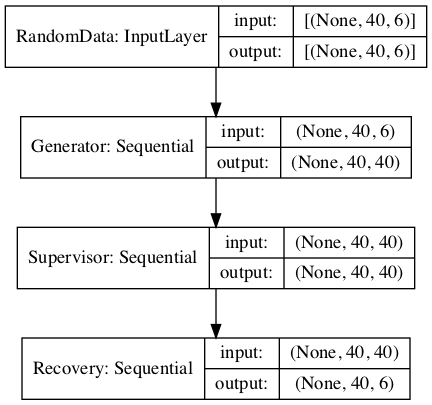

In [42]:
plot_model(synthetic_data, show_shapes=True)

In [43]:
def get_generator_moment_loss(y_true, y_pred):
    y_true_mean, y_true_var = tf.nn.moments(x=y_true, axes=[0])
    y_pred_mean, y_pred_var = tf.nn.moments(x=y_pred, axes=[0])

    g_loss_mean = tf.reduce_mean(tf.abs(y_true_mean - y_pred_mean))
    g_loss_var = tf.reduce_mean(tf.abs(tf.sqrt(y_true_var + 1e-6) - tf.sqrt(y_pred_var + 1e-6)))
    return g_loss_mean + g_loss_var

In [44]:
#   Discriminator
Y_real = discriminator(H)
discriminator_model = Model(inputs=X, outputs = Y_real, name='DiscriminatorReal')
discriminator_model.summary()

Model: "DiscriminatorReal"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
RealData (InputLayer)        [(None, 40, 6)]           0         
_________________________________________________________________
Embedder (Sequential)        (None, 40, 40)            27080     
_________________________________________________________________
Discriminator (Sequential)   (None, 40, 1)             29561     
Total params: 56,641
Trainable params: 56,641
Non-trainable params: 0
_________________________________________________________________


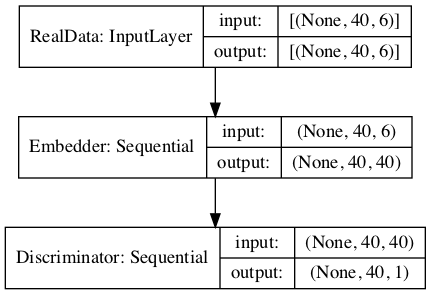

In [45]:
plot_model(discriminator_model, show_shapes=True)

In [46]:
#   Optimizers

generator_optimizer = Adam()
discriminator_optimizer = Adam()
embedder_optimizer = Adam()

In [47]:
#   Generator train step
@tf.function
def train_generator(x,z):
    with tf.GradientTape() as tape:
        y_fake = adversarial_supervised(z)
        generator_loss_unsupervised = bce(y_true=tf.ones_like(y_fake), y_pred=y_fake)
        y_fake_e = adversarial_emb(z)
        generator_loss_unsupervised_e = bce(y_true=tf.ones_like(y_fake_e), y_pred=y_fake_e)

        h = embedder(x)
        h_hat_supervised = supervisor(h)
        generator_loss_supervised = mse(h[:, 1:, :], h_hat_supervised[:, 1:, :])

        x_hat = synthetic_data(z)
        generator_moment_loss = get_generator_moment_loss(x, x_hat)

        generator_loss = (generator_loss_unsupervised + generator_loss_unsupervised_e +
                          100 * tf.sqrt(generator_loss_supervised) +
                          100 * generator_moment_loss)

    var_list = generator.trainable_variables + supervisor.trainable_variables
    gradients = tape.gradient(generator_loss, var_list)
    generator_optimizer.apply_gradients(zip(gradients, var_list))
    return generator_loss_unsupervised, generator_loss_supervised, generator_moment_loss

In [48]:
#   Embedding train step
@tf.function
def train_emberdder(x):
    with tf.GradientTape() as tape:
        h = embedder(x)
        h_hat_supervised = supervisor(h)

        generator_loss_supervised = mse(h[:, 1:, :], h_hat_supervised[:, 1:, :])

        x_tilde = autoencoder(x)
        embedding_loss_t0 = mse(x, x_tilde)
        e_loss = 10 * tf.sqrt(embedding_loss_t0) + .1 * generator_loss_supervised

    var_list = embedder.trainable_variables + recovery.trainable_variables
    gradients = tape.gradient(e_loss, var_list)
    embedder_optimizer.apply_gradients(zip(gradients, var_list))
    return tf.sqrt(embedding_loss_t0)

In [49]:
#   Discriminator train step
@tf.function
def get_discriminator_loss(x, z):
    y_real = discriminator_model(x)
    discriminator_loss_real = bce(y_true=tf.ones_like(y_real), y_pred=y_real)
    y_fake = adversarial_supervised(z)
    discriminator_loss_fake = bce(y_true=tf.zeros_like(y_fake), y_pred=y_fake)

    y_fake_e = adversarial_emb(z)
    discriminator_loss_fake_e = bce(y_true=tf.zeros_like(y_fake_e), y_pred=y_fake_e)
    return (discriminator_loss_real +
            discriminator_loss_fake +
            gamma * discriminator_loss_fake_e)

@tf.function
def train_discriminator(x, z):
    with tf.GradientTape() as tape:
        discriminator_loss = get_discriminator_loss(x, z)

    var_list = discriminator.trainable_variables
    gradients = tape.gradient(discriminator_loss, var_list)
    discriminator_optimizer.apply_gradients(zip(gradients, var_list))
    return discriminator_loss

In [50]:
#   Training cell

step_g_loss_u = step_g_loss_s = step_g_loss_v = _step_e_loss_t0 = step_d_loss = 0
for step in tqdm(range(train_steps)):
    #   Generator
    for kk in range(2):
        _X = next(real_time_series_iter)
        _Z = next(random_time_series)

        #   Train Generator
        step_g_loss_u, step_g_loss_s, step_g_loss_v = train_generator(_X, _Z)
        #   Train Embedder
        _step_e_loss_t0 = train_emberdder(_X)
    _X = next(real_time_series_iter)
    _Z = next(random_time_series)
    step_d_loss = get_discriminator_loss(_X, _Z)
    if step_d_loss > .15:
        step_d_loss = train_discriminator(_X, _Z)

    if step % 100 == 0:
        print(f'{step:6,.0f} | d_loss: {step_d_loss:6.4f} | g_loss_u: {step_g_loss_u:6.4f} | '
              f'g_loss_s: {step_g_loss_s:6.4f} | g_loss_v: {step_g_loss_v:6.4f} | e_loss_t0: {_step_e_loss_t0:6.4f}')

    with writer.as_default():
        tf.summary.scalar('G Loss S', step_g_loss_s, step=step)
        tf.summary.scalar('G Loss U', step_g_loss_u, step=step)
        tf.summary.scalar('G Loss V', step_g_loss_v, step=step)
        tf.summary.scalar('E Loss T0', _step_e_loss_t0, step=step)
        tf.summary.scalar('D Loss', step_d_loss, step=step)

  0%|          | 0/10000 [00:00<?, ?it/s]

     0 | d_loss: 2.2796 | g_loss_u: 0.5480 | g_loss_s: 0.0008 | g_loss_v: 0.3589 | e_loss_t0: 0.0599
   100 | d_loss: 0.9876 | g_loss_u: 2.3039 | g_loss_s: 0.0003 | g_loss_v: 0.0999 | e_loss_t0: 0.0063
   200 | d_loss: 0.5553 | g_loss_u: 2.9702 | g_loss_s: 0.0001 | g_loss_v: 0.0478 | e_loss_t0: 0.0059
   300 | d_loss: 0.4493 | g_loss_u: 3.3747 | g_loss_s: 0.0002 | g_loss_v: 0.0453 | e_loss_t0: 0.0051
   400 | d_loss: 1.2213 | g_loss_u: 2.7061 | g_loss_s: 0.0003 | g_loss_v: 0.0473 | e_loss_t0: 0.0053
   500 | d_loss: 0.6421 | g_loss_u: 2.9036 | g_loss_s: 0.0002 | g_loss_v: 0.0554 | e_loss_t0: 0.0051
   600 | d_loss: 1.1425 | g_loss_u: 2.9665 | g_loss_s: 0.0002 | g_loss_v: 0.0719 | e_loss_t0: 0.0054
   700 | d_loss: 1.4138 | g_loss_u: 1.0068 | g_loss_s: 0.0004 | g_loss_v: 0.0688 | e_loss_t0: 0.0052
   800 | d_loss: 1.2117 | g_loss_u: 1.2066 | g_loss_s: 0.0001 | g_loss_v: 0.0329 | e_loss_t0: 0.0047
   900 | d_loss: 1.3946 | g_loss_u: 1.2483 | g_loss_s: 0.0003 | g_loss_v: 0.0498 | e_loss_t

In [51]:
synthetic_data.save(logger_directory / 'synthetic_data')

INFO:tensorflow:Assets written to: GAN_DATA/experiment_00/synthetic_data/assets


INFO:tensorflow:Assets written to: GAN_DATA/experiment_00/synthetic_data/assets


In [247]:
generated_data = []
for i in range(int(n_windows / batch_size)):
    Z_ = next(random_time_series)
    d = synthetic_data(Z_)
    generated_data.append(d)


generated_data = np.array(np.vstack(generated_data))
generated_data.shape

(4480, 40, 6)

In [53]:
np.save(logger_directory / 'generated_data.npy', generated_data)

#   Plotting & Rescaling

In [248]:
generated_data = (sk_scaler.inverse_transform(generated_data
                                           .reshape(-1, numbers_sequences))
                  .reshape(-1, sequence_length, numbers_sequences))
generated_data.shape

(4480, 40, 6)

6

In [55]:
with pd.HDFStore(hdf_store) as store:
    store.put('data/synthetic', pd.DataFrame(generated_data.reshape(-1, numbers_sequences),
                                             columns=tickers))

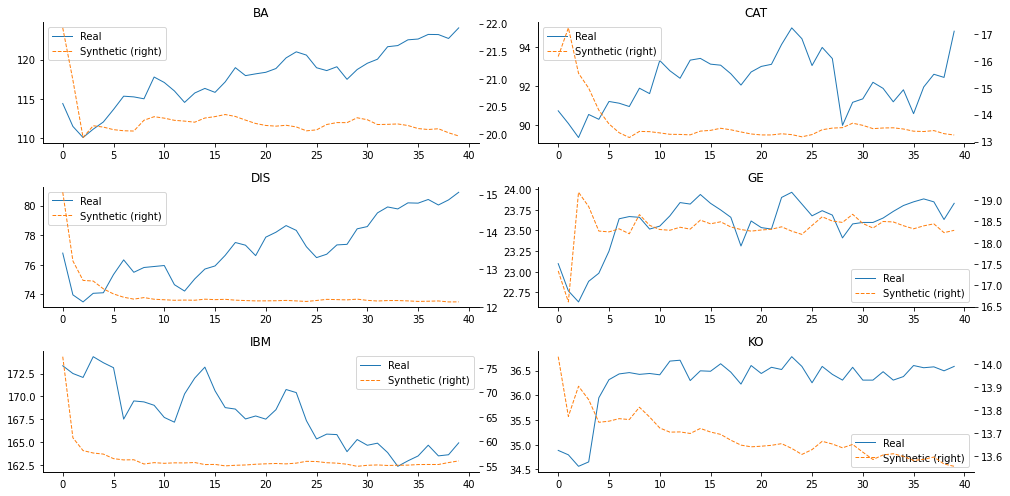

In [251]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14, 7))
axes = axes.flatten()

index = list(range(1, 25))
synthetic = generated_data[np.random.randint(n_windows)]

idx = np.random.randint(len(input_raw_data) - sequence_length)
#real = input_raw_data.iloc[idx: idx + sequence_length]
#   LESTRY
real = input_raw_data.iloc[idx: idx + sequence_length]
for j, ticker in enumerate(tickers):
    (pd.DataFrame({'Real': real.iloc[:, j].values,
                   'Synthetic': synthetic[:, j]})
     .plot(ax=axes[j],
           title=ticker,
           secondary_y='Synthetic', style=['-', '--'],
           lw=1))
sns.despine()
fig.tight_layout()

200
198


<Figure size 720x432 with 0 Axes>

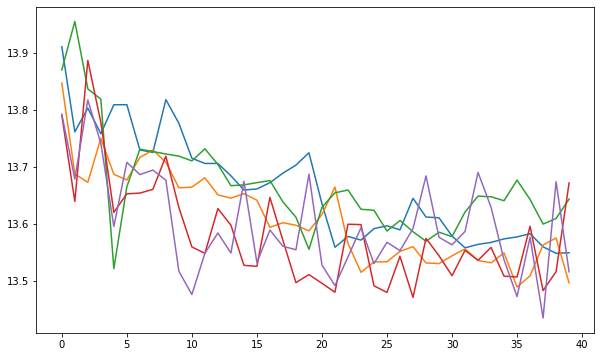

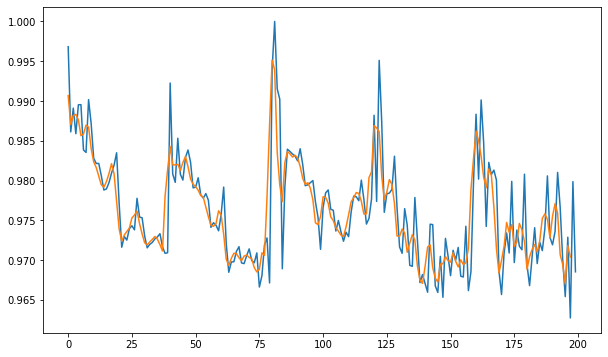

In [362]:
def gen_synthetic_data():
    def geplotting():
        generation = generated_data[np.random.randint(2240)][:,5]
        while generation.std() > 0.10:
            generation = generated_data[np.random.randint(2240)][:,5]
        plt.plot(generation)
        return generation
    plot_data = np.array([])
    plt.figure(figsize=(10,6))
    i = 0
    while i < 5:
        generation_data = geplotting()
        if (i != 0) and (max(generation_data[0] / plot_data[-1], plot_data[-1] / generation_data[0]) < 1.5):
            plot_data = np.hstack((plot_data, generation_data))
            i += 1
        if (i == 0):
            plot_data = np.hstack((plot_data, generation_data))
            i += 1
    plt.figure(figsize=(10,6))
    plt.plot(plot_data / max(plot_data))
    return plot_data / max(plot_data)

plt.figure(figsize=(10,6))

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w


synth = gen_synthetic_data()
print(len(synth))
moving = moving_average(synth, 3)
print(len(moving))
plt.plot(moving)

16.416356703764592